In [1]:
import functools
import pickle
import sys

import matplotlib as mpl
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import numpy.typing as npt
import pandas as pd
import torch
from matplotlib.animation import FuncAnimation
from tqdm.auto import trange

sys.path.append("..")

from burgers.approximator import BurgersApproximator
from burgers.plot import plot_1d_image, plot_2d, plot_2d_snapshot
from burgers.trajectory import IsDivergingPrecise, compare_trajectory
from neural_rk.grid_graph import dxdy2pos, edge2dxdy, node2grid
from neural_rk.hyperparameter import HyperParameter
from neural_rk.modules import RungeKutta, prune_state_dict
from neural_rk.path import DATA_DIR, FIG_DIR, RESULT_DIR
from neural_rk.scheduler import get_scheduler
from neural_rk.trainer import rollout

mpl.rcParams["font.family"] = "serif"
# mpl.rcParams["text.usetex"] = True
mpl.rcParams["text.latex.preamble"] = r"\usepackage{amsmath, amssymb}"

In [50]:
device = torch.device("cuda:0")
exp_id = "G"
test_id = "G_train"
result_dir = RESULT_DIR / f"burgers_{exp_id}"

# Load hyperparameter
hp = HyperParameter.from_yaml(result_dir / "hyperparameter.yaml")

# Load checkpoint
checkpoint = torch.load(result_dir / "best.pth", map_location=device)

# Load MAE
mae_df = pd.read_csv(result_dir / "mae.txt", sep="\t")
train_mae, val_mae = mae_df["train_mae"], mae_df["val_mae"]
rollout_mae = mae_df["rollout_mae"]
best_epoch = np.argmin(rollout_mae).item()

# Load test data
test_df = pd.read_pickle(DATA_DIR / f"burgers_{test_id}.pkl")
times = np.stack(  # [num_sample, S+1]
    [np.insert(np.cumsum(dts.numpy()), 0, 0.0) for dts in test_df.dts], axis=0
)

# [num_sample, S+1, N(Nx*Ny), 2]
true_trajectories = [traj.numpy() for traj in test_df.trajectories]

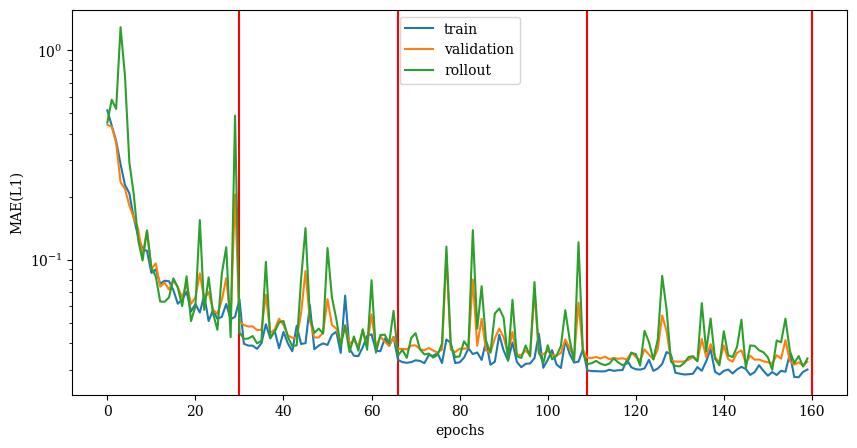

In [44]:
# Plot train history
fig, ax = plt.subplots(figsize=(10, 5))

schedular = get_scheduler(hp.scheduler)
for cycle in schedular.get_updated_epochs(hp.scheduler, len(train_mae)):
    plt.axvline(cycle, color="r")

ax.plot(train_mae, label="train")
ax.plot(val_mae, label="validation")
ax.plot(rollout_mae, label="rollout")
ax.set_xlabel("epochs")
ax.set_ylabel("MAE(L1)")
ax.set_yscale("log")
ax.legend()

fig.show()

# Rollout

In [51]:
approximator = BurgersApproximator.from_hp(hp.approximator)
approximator.load_state_dict(prune_state_dict(checkpoint["best_model_state_dict"]))
# model = RungeKutta(approximator, butcher_tableau=hp.rk).to(device)
model = RungeKutta(approximator, butcher_tableau="rk4").to(device)

burgers_rollout = functools.partial(
    rollout,
    model=model,
    use_amp=hp.amp,
    device=device,
    is_diverging=IsDivergingPrecise(),
)

pred_trajectories: list[npt.NDArray[np.float32]] = []
for idx in trange(len(test_df)):
    pred_trajectories.append(burgers_rollout(series=test_df.iloc[idx]).cpu().numpy())

  0%|          | 0/20 [00:00<?, ?it/s]

In [52]:
with open(result_dir / f"pred_{test_id}.pkl", "wb") as f:
    pickle.dump(pred_trajectories, f)

# with open(result_dir / f"pred_{test_id}.pkl", "rb") as f:
#     pred_trajectories = pickle.load(f)

# Analyze

In [53]:
maes = []   # [num_sample, S, 2]
for idx, (true, pred) in enumerate(zip(true_trajectories, pred_trajectories)):
    print(f"{idx=}, {test_df.network_type[idx]}, N={true.shape[1]}", end=" ")
    maes.append(compare_trajectory(true, pred))
# maes = np.stack(maes, axis=0)  # [num_sample, S, 2]
print(f"Error: MAE={np.mean(maes):.4e} \t std={np.std(maes):.4e}")

idx=0, 131_58, N=7598 MAE: 0.0033, Maximum err: 0.0367 at step=395, node=7402, field=v
idx=1, 127_119, N=15113 MAE: 0.0024, Maximum err: 0.0171 at step=308, node=7684, field=u
idx=2, 87_125, N=10875 MAE: 0.0025, Maximum err: 0.0168 at step=405, node=5478, field=v
idx=3, 146_77, N=11242 MAE: 0.0033, Maximum err: 0.0302 at step=375, node=5981, field=v
idx=4, 89_129, N=11481 MAE: 0.0025, Maximum err: 0.0193 at step=360, node=11171, field=v
idx=5, 133_65, N=8645 MAE: 0.0029, Maximum err: 0.0254 at step=229, node=4661, field=u
idx=6, 134_122, N=16348 MAE: 0.0026, Maximum err: 0.0180 at step=336, node=8510, field=u
idx=7, 81_126, N=10206 MAE: 0.0027, Maximum err: 0.0209 at step=400, node=5147, field=u
idx=8, 120_105, N=12600 MAE: 0.0023, Maximum err: 0.0172 at step=327, node=6540, field=u
idx=9, 83_83, N=6889 MAE: 0.0024, Maximum err: 0.0180 at step=583, node=500, field=v
idx=10, 93_116, N=10788 MAE: 0.0022, Maximum err: 0.0140 at step=217, node=8188, field=u
idx=11, 122_60, N=7320 MAE: 0.00

In [10]:
# true_trajectories: list[npt.NDArray[np.float32]] = [traj.numpy() for traj in test_df.trajectories]

# maes = []
# for idx, true in enumerate(true_trajectories):
#     print(f"{idx=}, {test_df.network_type[idx]}, N={true.shape[1]}", end=" ")
#     dummy = np.stack([true[0] for _ in range(len(true))], axis=0)
#     maes.append(compare_trajectory(true, dummy))
# maes = np.stack(maes, axis=0)  # (# of samples, S, 3)
# print(f"Error: MAE={np.mean(maes):.4e} \t std={np.std(maes):.4e}")

# Statistics over samples

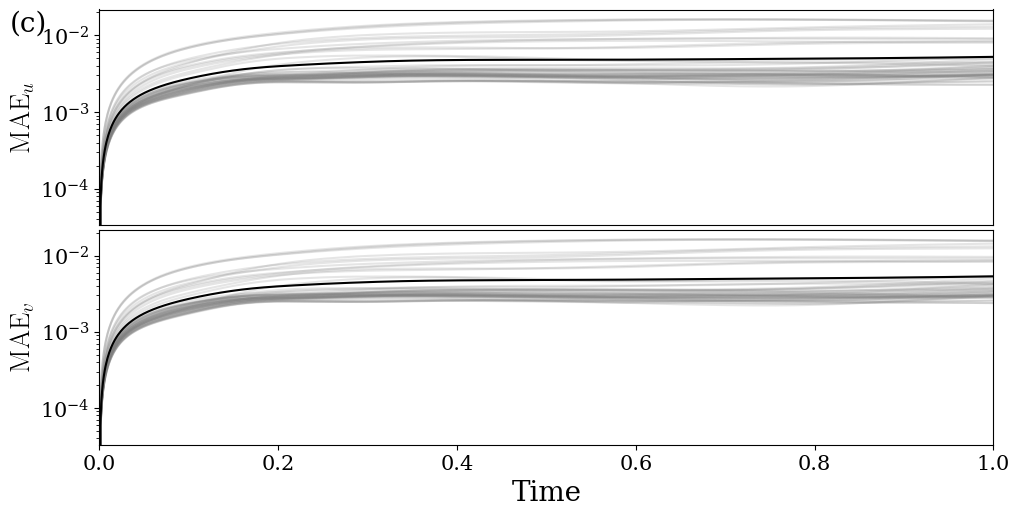

In [48]:
fig, (ax1, ax2) = plt.subplots(figsize=(10, 5), nrows=2)

for sample_time, sample_mae in zip(times, maes):
    ax1.plot(sample_time, sample_mae[..., 0], color="gray", alpha=0.2)
    ax2.plot(sample_time, sample_mae[..., 1], color="gray", alpha=0.2)

t = np.linspace(0.0, times[:, -1].mean(), len(times[0]), dtype=np.float32)
final_mae = np.mean(maes, axis=0)
ax1.plot(t, final_mae[..., 0], color="k")
ax2.plot(t, final_mae[..., 1], color="k")

ax1.set_yscale("log")
ax2.set_yscale("log")
ax1.set_xlim(0.0, 1.0)
ax2.set_xlim(0.0, 1.0)
ax1.set_xticks([])
ax2.set_xlabel("Time", fontsize=20)
ax1.set_ylabel(r"$\text{MAE}_u$", fontsize=20, usetex=True)
ax2.set_ylabel(r"$\text{MAE}_v$", fontsize=20, usetex=True)
ax1.tick_params(axis="both", labelsize=15)
ax2.tick_params(axis="both", labelsize=15)
ax1.text(-0.1, 0.9, "(c)", fontsize=20, transform=ax1.transAxes)


fig.tight_layout(pad=0.0)
# fig.savefig(
#     f"{FIG_DIR}/burgers_mae_{test_id}_{exp_id}.pdf", bbox_inches="tight", pad_inches=0.0
# )

fig.show()

# Single sample

In [4]:
sample_idx = 6
test_data = test_df.iloc[sample_idx]
Nx, Ny = map(int, str(test_data.network_type).split("_"))

time = times[sample_idx]    # [S+1, ]
true_trajectory = true_trajectories[sample_idx]  # [N, 2]
pred_trajectory = pred_trajectories[sample_idx]  # [N, 2]
error = true_trajectory - pred_trajectory   # [N, 2]
print(f"MAE={np.abs(error).mean():.4e}, in range {error.min():.4f}, {error.max():.4f}")


MAE=2.6130e-03, in range -0.0199, 0.0269


### 1D

In [8]:
(dx,) = edge2dxdy(test_data.edge_attr, Nx)
pos = dxdy2pos(dx)

true_trajectory = true_trajectory[..., 0:1]
pred_trajectory = pred_trajectory[..., 0:1]
error = error[..., 0:1]
print(f"{error.max():.2e}, {error.min():.2e}")


2.09e-03, -8.43e-04


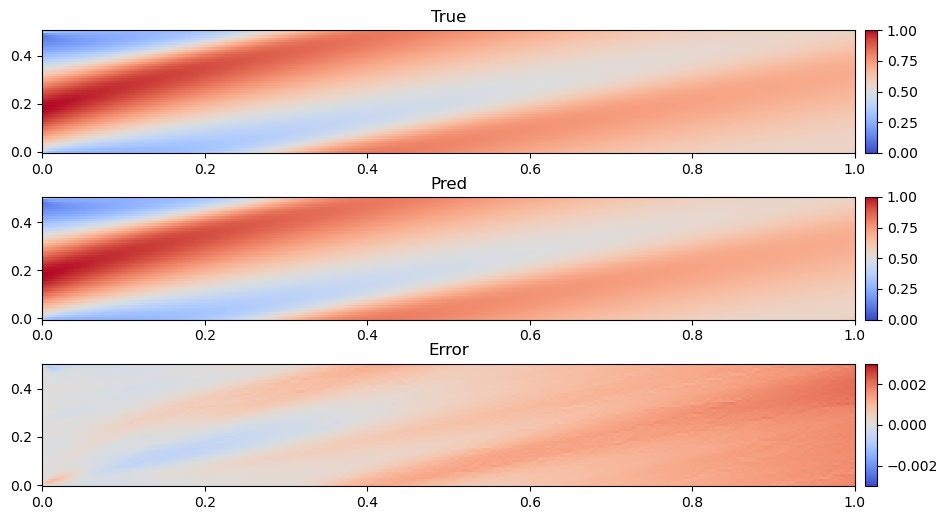

In [10]:


fig, (ax1, ax2, ax3) = plt.subplots(figsize=(10, 5), nrows=3)

im1 = plot_1d_image(ax1, time, pos, true_trajectory, rasterized=True)
ax1.set_title("True")
cbar1 = fig.colorbar(im1, ax=ax1, location="right", pad=0.01, aspect=10)

im2 = plot_1d_image(ax2, time, pos, pred_trajectory, rasterized=True)
ax2.set_title("Pred")
cbar2 = fig.colorbar(im2, ax=ax2, location="right", pad=0.01, aspect=10)

im3 = plot_1d_image(ax3, time, pos, error, lim=(-0.003, 0.003), rasterized=True)
ax3.set_title("Error")
cbar3 = fig.colorbar(im3, ax=ax3, location="right", pad=0.01, aspect=10)

fig.tight_layout(pad=0.0)
fig.show()

### 2D

In [6]:
dx, dy = edge2dxdy(test_data.edge_attr, Nx, Ny)
pos = dxdy2pos(dx, dy)
xticks = np.linspace(0, pos.shape[1] - 1, num=5)
xticklabels = np.round(np.linspace(0.0, pos[0, -1, 0], num=len(xticks)), 2)
yticks = np.linspace(0, pos.shape[0] - 1, num=5)
yticklabels = np.round(np.linspace(0.0, pos[-1, 0, 1], num=len(yticks)), 2)

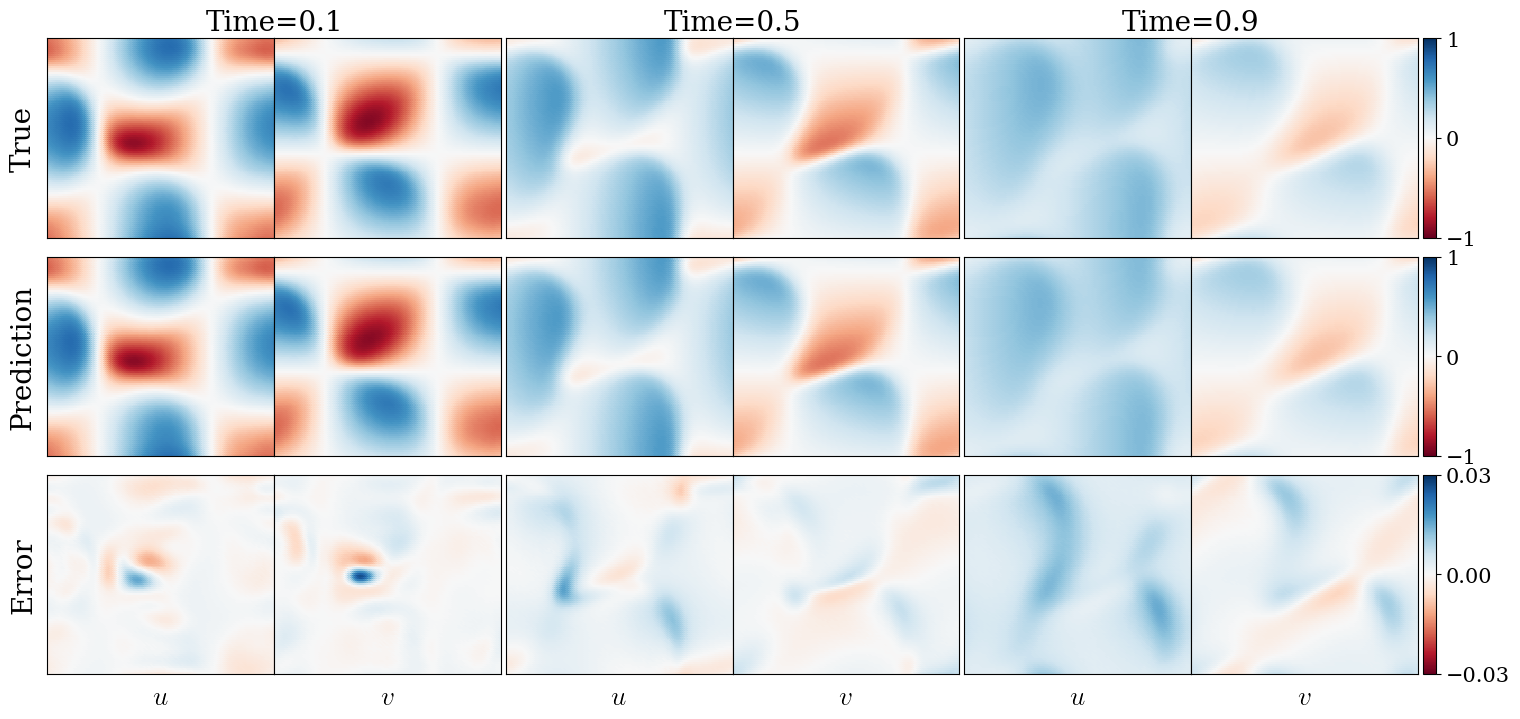

In [7]:
fig = plt.figure(figsize=(15, 7))
gs = gridspec.GridSpec(3, 4, figure=fig, width_ratios=[0.33, 0.33, 0.33, 0.01])

def true_pred_error(gses: list[gridspec.SubplotSpec], frame: int, rasterized: bool = False, ylabel: bool = False):
    gs0 = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gses[0], wspace=0.0)
    ax_title = fig.add_subplot(gs0[:])
    ax_title.axis("off")
    ax_title.set_title(f"Time={time[frame]:.1f}", fontsize=20)
    (ax1, ax2) = gs0.subplots(sharex=True, sharey=True)
    im1, _ = plot_2d_snapshot(ax1, ax2, pos, node2grid(true_trajectory[frame], Nx, Ny), rasterized=rasterized)

    gs1 = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gses[1], wspace=0.0)
    (ax3, ax4) = gs1.subplots(sharex=True, sharey=True)
    im2, _ = plot_2d_snapshot(ax3, ax4, pos, node2grid(pred_trajectory[frame], Nx, Ny), rasterized=rasterized)

    gs2 = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gses[2], wspace=0.0)
    (ax5, ax6) = gs2.subplots(sharex=True, sharey=True)
    im3, _ = plot_2d_snapshot(ax5, ax6, pos, node2grid(error[frame], Nx, Ny), lim=(-0.03, 0.03), rasterized=rasterized)
    ax5.set_xlabel("$u$", usetex=True, fontsize=20)
    ax6.set_xlabel("$v$", usetex=True, fontsize=20)

    if ylabel:
        ax1.set_ylabel("True", fontsize=20)
        ax3.set_ylabel("Prediction", fontsize=20)
        ax5.set_ylabel("Error", fontsize=20)

    return im1, im2, im3

frame = 100
true_pred_error([gs[0, 0], gs[1, 0], gs[2, 0]], frame, rasterized=True, ylabel=True)
frame = 500
true_pred_error([gs[0, 1], gs[1, 1], gs[2, 1]], frame, rasterized=True)
frame = 900
im1, im2, im3 = true_pred_error([gs[0, 2], gs[1, 2], gs[2, 2]], frame, rasterized=True)

ax_cbar1 = fig.add_subplot(gs[0, 3])
fig.colorbar(im1, ax_cbar1, ticks=[-1.0, 0.0, 1.0])
ax_cbar1.tick_params(labelsize=15)

ax_cbar2 = fig.add_subplot(gs[1, 3])
fig.colorbar(im2, ax_cbar2, ticks=[-1.0, 0.0, 1.0])
ax_cbar2.tick_params(labelsize=15)

ax_cbar3 = fig.add_subplot(gs[2, 3])
fig.colorbar(im3, ax_cbar3, ticks=[-0.03, 0.0, 0.03])
ax_cbar3.tick_params(labelsize=15)

fig.tight_layout(pad=0.0)
fig.savefig(
    f"{FIG_DIR}/burgers_{test_id}_{sample_idx}_{exp_id}.pdf",
    bbox_inches="tight",
    pad_inches=0.0,
)
fig.show()

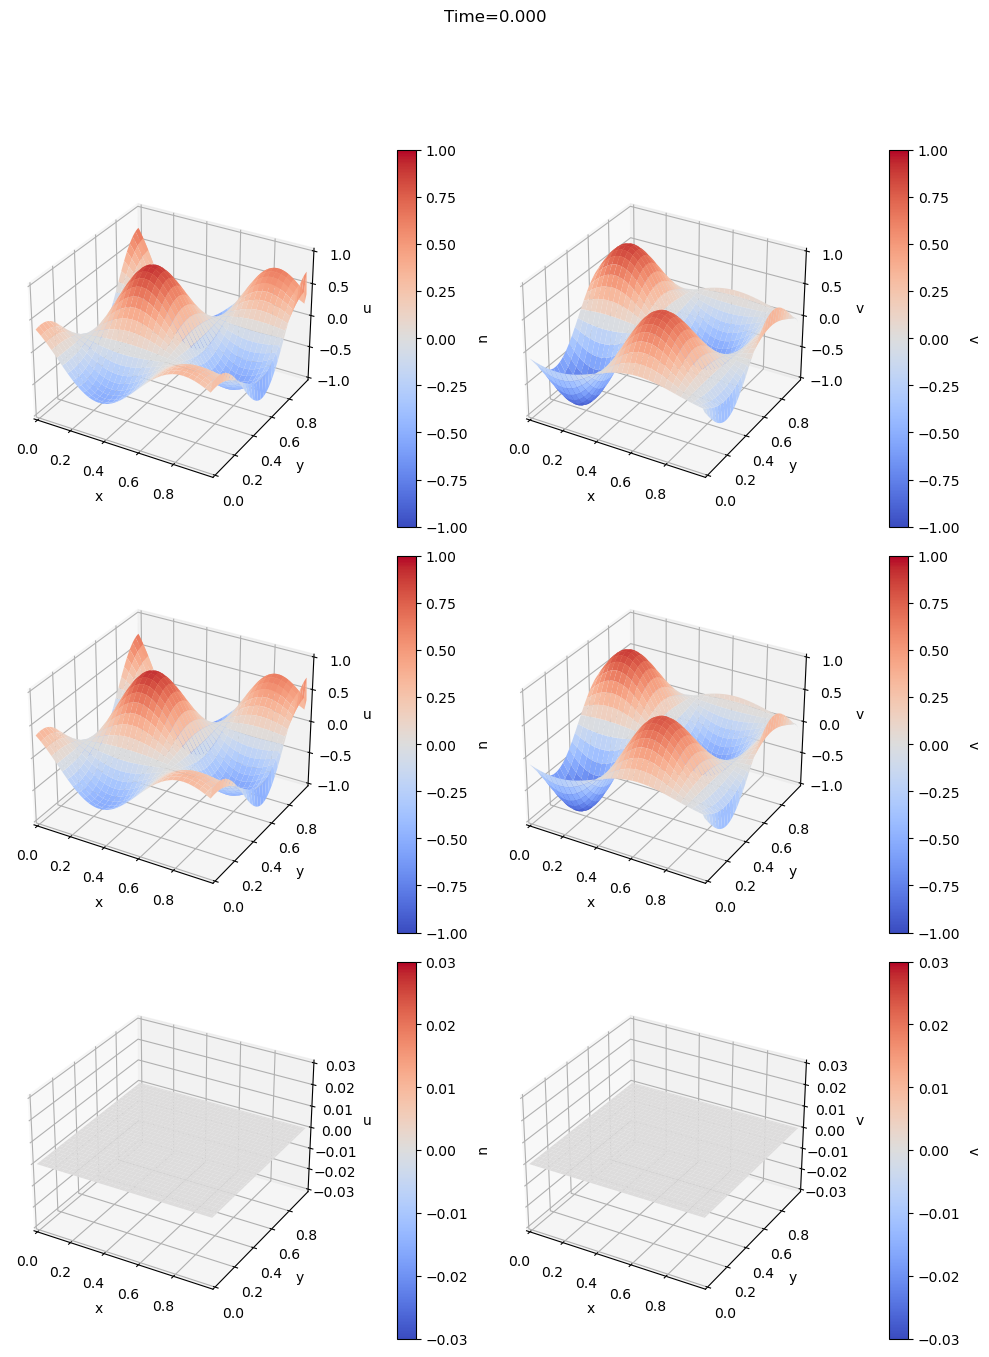

In [11]:
skip_frame = 10

fig = plt.figure(figsize=(10, 15))
ax1 = fig.add_subplot(321, projection="3d")
ax2 = fig.add_subplot(322, projection="3d")
ax3 = fig.add_subplot(323, projection="3d")
ax4 = fig.add_subplot(324, projection="3d")
ax5 = fig.add_subplot(325, projection="3d")
ax6 = fig.add_subplot(326, projection="3d")

ax1.set_title("True")
sf1, sf2 = plot_2d(ax1, ax2, pos, node2grid(true_trajectory[0], Nx, Ny))
cbar1 = ax1.figure.colorbar(sf1, ax=ax1, shrink=0.6, pad=0.15)
cbar1.ax.set_ylabel("u", rotation=-90, va="bottom")
cbar2 = ax2.figure.colorbar(sf2, ax=ax2, shrink=0.6, pad=0.15)
cbar2.ax.set_ylabel("v", rotation=-90, va="bottom")


ax3.set_title("Pred")
sf3, sf4 = plot_2d(ax3, ax4, pos, node2grid(pred_trajectory[0], Nx, Ny))
cbar3 = ax3.figure.colorbar(sf3, ax=ax3, shrink=0.6, pad=0.15)
cbar3.ax.set_ylabel("u", rotation=-90, va="bottom")
cbar4 = ax4.figure.colorbar(sf4, ax=ax4, shrink=0.6, pad=0.15)
cbar4.ax.set_ylabel("v", rotation=-90, va="bottom")

ax5.set_title("Error")
sf5, sf6 = plot_2d(ax5, ax6, pos, node2grid(error[0], Nx, Ny), lim=(-0.03, 0.03))
cbar5 = ax5.figure.colorbar(sf5, ax=ax5, shrink=0.6, pad=0.15)
cbar5.ax.set_ylabel("u", rotation=-90, va="bottom")
cbar6 = ax6.figure.colorbar(sf6, ax=ax6, shrink=0.6, pad=0.15)
cbar6.ax.set_ylabel("v", rotation=-90, va="bottom")
fig.tight_layout()


def update(frame: int) -> None:
    frame *= skip_frame
    ax1.clear()
    ax2.clear()
    ax3.clear()
    ax4.clear()
    ax5.clear()
    ax6.clear()
    plot_2d(ax1, ax2, pos, node2grid(true_trajectory[frame], Nx, Ny))
    plot_2d(ax3, ax4, pos, node2grid(pred_trajectory[frame], Nx, Ny))
    plot_2d(ax5, ax6, pos, node2grid(error[frame], Nx, Ny), lim=(-0.03, 0.03))
    fig.suptitle(f"Time={time[frame]:.3f}")
    fig.tight_layout()


# anim = FuncAnimation(fig, update, frames=int(len(pred_trajectory) / skip_frame), interval=50)
# anim.save(str(FIG_DIR / f"burgers_{test_id}_{sample_idx}_{exp_id}.gif"))

# MAE

In [54]:
def read_error(
    dataset: str,
) -> tuple[list[npt.NDArray[np.float32]], list[npt.NDArray[np.float32]]]:
    exp_id = dataset
    result_dir = RESULT_DIR / f"burgers_{exp_id}"
    test_id = f"{dataset}_test"

    # True values
    test_df = pd.read_pickle(DATA_DIR / f"burgers_{test_id}.pkl")
    times = [
        np.insert(np.cumsum(dts.numpy()), 0, 0.0) for dts in test_df.dts
    ]  # [num_sample, S+1]
    true_trajectories = [traj.numpy() for traj in test_df.trajectories]

    # Predicted values
    with open(result_dir / f"pred_{test_id}.pkl", "rb") as f:
        pred_trajectories = pickle.load(f)

    maes = []  # [num_sample, S]
    for true, pred in zip(true_trajectories, pred_trajectories):
        maes.append(compare_trajectory(true, pred, log=False).mean(axis=-1))

    return maes, times


maes_ic, times_ic = read_error("IC")
maes_p, times_p = read_error("P")
maes_g, times_g = read_error("G")
maes_rk, times_rk = read_error("RK")


In [30]:
def plot_mae(ax: plt.Axes, maes: list[npt.NDArray[np.float32]], times: list[npt.NDArray[np.float32]]):
    for sample_time, sample_mae in zip(times, maes):
        ax.plot(sample_time, sample_mae, color="gray", alpha=0.2)
    t = np.linspace(0.0, 1.0, len(times[0]), dtype=np.float32)
    final_mae = np.mean(maes, axis=0)
    ax.plot(t, final_mae, color="k")
    ax.set_yscale("log")
    ax.set_xlim(0.0, 1.0)
    ax.tick_params(axis="both", which="both", direction="in", labelsize=15)


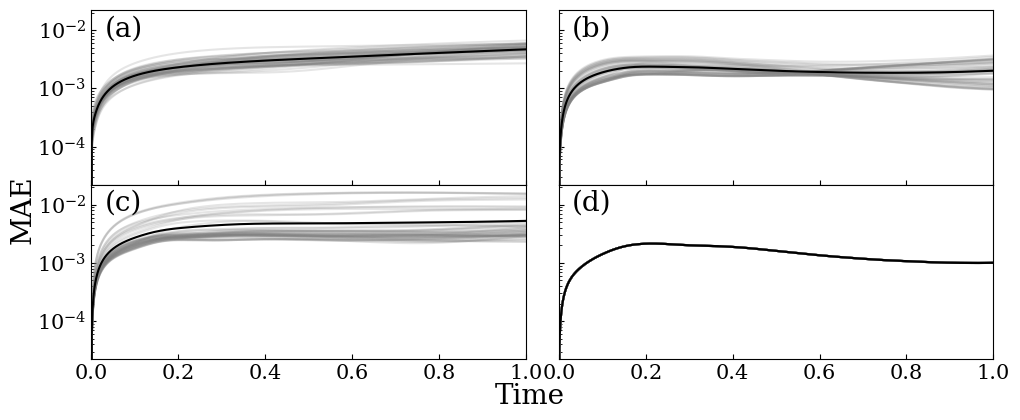

In [55]:
fig, axes = plt.subplots(figsize=(10, 4), nrows=2, ncols=2, sharex=True, sharey=True)

ax1, ax2 = axes[0]
ax3, ax4 = axes[1]

plot_mae(ax1, maes_ic, times_ic)
plot_mae(ax2, maes_p, times_p)
plot_mae(ax3, maes_g, times_g)
plot_mae(ax4, maes_rk, times_rk)

ax1.text(0.03, 0.85, "(a)", fontsize=20, transform=ax1.transAxes)
ax2.text(0.03, 0.85, "(b)", fontsize=20, transform=ax2.transAxes)
ax3.text(0.03, 0.85, "(c)", fontsize=20, transform=ax3.transAxes)
ax4.text(0.03, 0.85, "(d)", fontsize=20, transform=ax4.transAxes)

fig.supylabel("MAE", fontsize=20, x=0.0)
fig.supxlabel("Time", fontsize=20, x=0.52, y=0.0)
fig.tight_layout(pad=0.0)

fig.savefig(
    f"{FIG_DIR}/burgers_mae.pdf", bbox_inches="tight", pad_inches=0.0
)
fig.show()